<a href="https://colab.research.google.com/github/cptgingerbeard/good-fall/blob/main/excercise_pose_classifier_ido_video1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe
import cv2
import mediapipe as mp
print("MediaPipe imported successfully!")

import numpy as np
import pandas as pd
import tensorflow as tf
import keras

!pip install --upgrade numpy pandas tensorflow keras opencv-python mediapipe

MediaPipe imported successfully!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.

In [ ]:
import cv2
import mediapipe as mp
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import plotly.graph_objects as go
import imageio
import pickle
#import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

## Constants

In [ ]:
# Define all landmarks in uppercase
LANDMARKS = [
    "NOSE",
    "LEFT_EYE_INNER",
    "LEFT_EYE",
    "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER",
    "RIGHT_EYE",
    "RIGHT_EYE_OUTER",
    "LEFT_EAR",
    "RIGHT_EAR",
    "MOUTH_LEFT",
    "MOUTH_RIGHT",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_PINKY",
    "RIGHT_PINKY",
    "LEFT_INDEX",
    "RIGHT_INDEX",
    "LEFT_THUMB",
    "RIGHT_THUMB",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX"
]

BODY_ANGLES = ['left_elbow_angle',
 'right_elbow_angle',
 'left_armpit_angle',
 'right_armpit_angle',
 'left_hip_angle',
 'right_hip_angle',
 'left_knee_angle',
 'right_knee_angle',
 'left_side_collarbone_angle',
 'right_side_collarbone_angle']

BODY_HEIGHTS = [
    'shoulder_width_x', 'shoulder_width_y',
    'hip_width_x', 'hip_width_y',
    'left_elbow_wrist_distance_x', 'left_elbow_wrist_distance_y',
    'right_elbow_wrist_distance_x', 'right_elbow_wrist_distance_y',
    'left_elbow_shoulder_distance_x', 'left_elbow_shoulder_distance_y',
    'right_elbow_shoulder_distance_x', 'right_elbow_shoulder_distance_y',
    'left_shoulder_hip_alignment_x', 'left_shoulder_hip_alignment_y',
    'right_shoulder_hip_alignment_x', 'right_shoulder_hip_alignment_y',
    'left_knee_ankle_distance_x', 'left_knee_ankle_distance_y',
    'right_knee_ankle_distance_x', 'right_knee_ankle_distance_y',
    'left_knee_hip_distance_x', 'left_knee_hip_distance_y',
    'right_knee_hip_distance_x', 'right_knee_hip_distance_y',
    'left_hand_shoulder_distance_x', 'left_hand_shoulder_distance_y',
    'right_hand_shoulder_distance_x', 'right_hand_shoulder_distance_y',
    'left_hand_nose_distance_x', 'left_hand_nose_distance_y',
    'right_hand_nose_distance_x', 'right_hand_nose_distance_y',
    'left_hand_hip_distance_x', 'left_hand_hip_distance_y',
    'right_hand_hip_distance_x', 'right_hand_hip_distance_y',
    'foot_spread_x', 'foot_spread_y'
]


## Helper Functions

In [ ]:
# Helper function to get coordinates of a landmark
def get_coords(landmark, df_frame):
    coords = df_frame[df_frame['landmark'] == landmark][['x', 'y', 'z']].values
    return coords[0] if len(coords) > 0 else None

# Calculate vector between two points
def calc_vector(p1, p2):
    return np.array(p2) - np.array(p1)

# Calculate angle between two vectors using the dot product
def angle_between(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    cos_theta = dot_product / (norm_v1 * norm_v2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

def get_body_vecs(coordinates):
    # Upper arms
    left_upper_arm = calc_vector(coordinates['LEFT_SHOULDER'], coordinates['LEFT_ELBOW'])
    right_upper_arm = calc_vector(coordinates['RIGHT_SHOULDER'], coordinates['RIGHT_ELBOW'])

    # Forearms
    left_forearm = calc_vector(coordinates['LEFT_ELBOW'], coordinates['LEFT_WRIST'])
    right_forearm = calc_vector(coordinates['RIGHT_ELBOW'], coordinates['RIGHT_WRIST'])

    # Upper legs
    left_upper_leg = calc_vector(coordinates['LEFT_HIP'], coordinates['LEFT_KNEE'])
    right_upper_leg = calc_vector(coordinates['RIGHT_HIP'], coordinates['RIGHT_KNEE'])

    # Lower legs
    left_lower_leg = calc_vector(coordinates['LEFT_KNEE'], coordinates['LEFT_ANKLE'])
    right_lower_leg = calc_vector(coordinates['RIGHT_KNEE'], coordinates['RIGHT_ANKLE'])

    # Groin (hip-to-hip vector)
    groin = calc_vector(coordinates['LEFT_HIP'], coordinates['RIGHT_HIP'])

    # Collarbones (shoulder-to-shoulder vector)
    collarbones = calc_vector(coordinates['LEFT_SHOULDER'], coordinates['RIGHT_SHOULDER'])

    # Sides
    right_side = calc_vector(coordinates['RIGHT_SHOULDER'], coordinates['RIGHT_HIP'])
    left_side = calc_vector(coordinates['LEFT_SHOULDER'], coordinates['LEFT_HIP'])

    # Return all vectors in a dictionary
    return {
        "left_upper_arm": left_upper_arm,
        "right_upper_arm": right_upper_arm,
        "left_forearm": left_forearm,
        "right_forearm": right_forearm,
        "left_upper_leg": left_upper_leg,
        "right_upper_leg": right_upper_leg,
        "left_lower_leg": left_lower_leg,
        "right_lower_leg": right_lower_leg,
        "groin": groin,
        "collarbones": collarbones,
        "right_side": right_side,
        "left_side": left_side
    }

# Calculate Angles
def calculate_body_angles(vectors):
    # Elbow angles (between upper arm and forearm)
    left_elbow_angle = angle_between(vectors['left_upper_arm'], vectors['left_forearm'])
    right_elbow_angle = angle_between(vectors['right_upper_arm'], vectors['right_forearm'])

    # Armpit angles (between upper arm and collarbones)
    left_armpit_angle = angle_between(vectors['left_upper_arm'], vectors['collarbones'])
    right_armpit_angle = angle_between(vectors['right_upper_arm'], vectors['collarbones'])

    # Hip angles (between upper leg and side vectors, representing torso alignment)
    left_hip_angle = angle_between(vectors['left_upper_leg'], vectors['left_side'])
    right_hip_angle = angle_between(vectors['right_upper_leg'], vectors['right_side'])

    # Knee angles (between upper leg and lower leg)
    left_knee_angle = angle_between(vectors['left_upper_leg'], vectors['left_lower_leg'])
    right_knee_angle = angle_between(vectors['right_upper_leg'], vectors['right_lower_leg'])

    # Side to collarbone angles (lateral torso tilt)
    left_side_collarbone_angle = angle_between(vectors['left_side'], vectors['collarbones'])
    right_side_collarbone_angle = angle_between(vectors['right_side'], vectors['collarbones'])

    # Return all angles in a dictionary
    return {
        "left_elbow_angle": left_elbow_angle,
        "right_elbow_angle": right_elbow_angle,
        "left_armpit_angle": left_armpit_angle,
        "right_armpit_angle": right_armpit_angle,
        "left_hip_angle": left_hip_angle,
        "right_hip_angle": right_hip_angle,
        "left_knee_angle": left_knee_angle,
        "right_knee_angle": right_knee_angle,
        "left_side_collarbone_angle": left_side_collarbone_angle,
        "right_side_collarbone_angle": right_side_collarbone_angle
    }

# Helper function to calculate differences in x and y directions between two points
def calc_xy_difference(p1, p2):
    return p2[0] - p1[0], p2[1] - p1[1]

# Calculate Heights
def calculate_body_heights(coordinates):
    # Calculate relevant x and y differences
    heights = {
        # Shoulder width (left shoulder to right shoulder)
        "shoulder_width_x": calc_xy_difference(coordinates['LEFT_SHOULDER'], coordinates['RIGHT_SHOULDER'])[0],
        "shoulder_width_y": calc_xy_difference(coordinates['LEFT_SHOULDER'], coordinates['RIGHT_SHOULDER'])[1],

        # Hip width (left hip to right hip)
        "hip_width_x": calc_xy_difference(coordinates['LEFT_HIP'], coordinates['RIGHT_HIP'])[0],
        "hip_width_y": calc_xy_difference(coordinates['LEFT_HIP'], coordinates['RIGHT_HIP'])[1],

        # Elbow-Wrist distance for arms
        "left_elbow_wrist_distance_x": calc_xy_difference(coordinates['LEFT_ELBOW'], coordinates['LEFT_WRIST'])[0],
        "left_elbow_wrist_distance_y": calc_xy_difference(coordinates['LEFT_ELBOW'], coordinates['LEFT_WRIST'])[1],
        "right_elbow_wrist_distance_x": calc_xy_difference(coordinates['RIGHT_ELBOW'], coordinates['RIGHT_WRIST'])[0],
        "right_elbow_wrist_distance_y": calc_xy_difference(coordinates['RIGHT_ELBOW'], coordinates['RIGHT_WRIST'])[1],

        # Elbow-Shoulder distance for arms
        "left_elbow_shoulder_distance_x": calc_xy_difference(coordinates['LEFT_ELBOW'], coordinates['LEFT_SHOULDER'])[0],
        "left_elbow_shoulder_distance_y": calc_xy_difference(coordinates['LEFT_ELBOW'], coordinates['LEFT_SHOULDER'])[1],
        "right_elbow_shoulder_distance_x": calc_xy_difference(coordinates['RIGHT_ELBOW'], coordinates['RIGHT_SHOULDER'])[0],
        "right_elbow_shoulder_distance_y": calc_xy_difference(coordinates['RIGHT_ELBOW'], coordinates['RIGHT_SHOULDER'])[1],

        # Shoulder-Hip alignment for left and right sides
        "left_shoulder_hip_alignment_x": calc_xy_difference(coordinates['LEFT_SHOULDER'], coordinates['LEFT_HIP'])[0],
        "left_shoulder_hip_alignment_y": calc_xy_difference(coordinates['LEFT_SHOULDER'], coordinates['LEFT_HIP'])[1],
        "right_shoulder_hip_alignment_x": calc_xy_difference(coordinates['RIGHT_SHOULDER'], coordinates['RIGHT_HIP'])[0],
        "right_shoulder_hip_alignment_y": calc_xy_difference(coordinates['RIGHT_SHOULDER'], coordinates['RIGHT_HIP'])[1],

        # Knee-Ankle distance for legs
        "left_knee_ankle_distance_x": calc_xy_difference(coordinates['LEFT_KNEE'], coordinates['LEFT_ANKLE'])[0],
        "left_knee_ankle_distance_y": calc_xy_difference(coordinates['LEFT_KNEE'], coordinates['LEFT_ANKLE'])[1],
        "right_knee_ankle_distance_x": calc_xy_difference(coordinates['RIGHT_KNEE'], coordinates['RIGHT_ANKLE'])[0],
        "right_knee_ankle_distance_y": calc_xy_difference(coordinates['RIGHT_KNEE'], coordinates['RIGHT_ANKLE'])[1],

        # Knee-Hip distance for legs
        "left_knee_hip_distance_x": calc_xy_difference(coordinates['LEFT_KNEE'], coordinates['LEFT_HIP'])[0],
        "left_knee_hip_distance_y": calc_xy_difference(coordinates['LEFT_KNEE'], coordinates['LEFT_HIP'])[1],
        "right_knee_hip_distance_x": calc_xy_difference(coordinates['RIGHT_KNEE'], coordinates['RIGHT_HIP'])[0],
        "right_knee_hip_distance_y": calc_xy_difference(coordinates['RIGHT_KNEE'], coordinates['RIGHT_HIP'])[1],

        # Wrist-Shoulder distance for arms
        "left_hand_shoulder_distance_x": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['LEFT_SHOULDER'])[0],
        "left_hand_shoulder_distance_y": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['LEFT_SHOULDER'])[1],
        "right_hand_shoulder_distance_x": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['RIGHT_SHOULDER'])[0],
        "right_hand_shoulder_distance_y": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['RIGHT_SHOULDER'])[1],

        # Wrist-Nose distance
        "left_hand_nose_distance_x": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['NOSE'])[0],
        "left_hand_nose_distance_y": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['NOSE'])[1],
        "right_hand_nose_distance_x": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['NOSE'])[0],
        "right_hand_nose_distance_y": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['NOSE'])[1],

        # Wrist-Hip distance
        "left_hand_hip_distance_x": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['LEFT_HIP'])[0],
        "left_hand_hip_distance_y": calc_xy_difference(coordinates['LEFT_WRIST'], coordinates['LEFT_HIP'])[1],
        "right_hand_hip_distance_x": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['RIGHT_HIP'])[0],
        "right_hand_hip_distance_y": calc_xy_difference(coordinates['RIGHT_WRIST'], coordinates['RIGHT_HIP'])[1],

        # Foot spread (left foot index to right foot index)
        "foot_spread_x": calc_xy_difference(coordinates['LEFT_FOOT_INDEX'], coordinates['RIGHT_FOOT_INDEX'])[0],
        "foot_spread_y": calc_xy_difference(coordinates['LEFT_FOOT_INDEX'], coordinates['RIGHT_FOOT_INDEX'])[1]
    }

    return heights


def calculate_angle(A, B, C):
    """
    Calculate the angle (in degrees) between vectors AB and BC.
    A, B, C are tuples representing (x, y) coordinates.
    """
    # Create vectors AB and BC
    AB = np.array([B[0] - A[0], B[1] - A[1]])
    BC = np.array([C[0] - B[0], C[1] - B[1]])

    # Calculate the dot product and magnitudes (norms) of the vectors
    dot_product = np.dot(AB, BC)
    magnitude_AB = np.linalg.norm(AB)
    magnitude_BC = np.linalg.norm(BC)

    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_AB * magnitude_BC)

    # Handle numerical precision issues (cosine should be between -1 and 1)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Calculate the angle in radians and convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

def create_features_per_excercise(video_folder, excercise_type,mp_pose):
    excercise_path = os.path.join(video_folder, excercise_type)  # Construct the full path
    vid_count = 0
    csv_data = []
    if os.path.isdir(excercise_path):  # Ensure it's a directory
        for video_file in tqdm(os.listdir(excercise_path)):
            video_path = os.path.join(excercise_path, video_file)
            # print(f"Processing video: {video_path}")

            # Open video file
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}.")
                continue
            vid_count += 1
            frame_number = 0

            # Initialize MediaPipe Pose with default settings
            with mp_pose.Pose() as pose:
                while cap.isOpened():
                    ret, frame = cap.read()

                    if not ret:
                        # print("End of video or failed to read frame.")
                        break

                    # Convert the frame to RGB (MediaPipe works with RGB images)
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    # Process the frame to detect pose landmarks
                    result = pose.process(frame_rgb)

                    # Draw pose landmarks if detected
                    if result.pose_landmarks:
                        for idx, landmark in enumerate(result.pose_landmarks.landmark):
                            # print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
                            csv_data.append([excercise_type,vid_count,frame_number, mp_pose.PoseLandmark(idx).name, landmark.x, landmark.y, landmark.z])
                    # Increment frame number
                    frame_number += 1
            # Release video capture and close all windows
            cap.release()
            cv2.destroyAllWindows()
    return csv_data

def feat_to_parquet(csv_data, excercise_name):
    df_feat = pd.DataFrame(csv_data)
    df_feat = df_feat.rename(columns={
        0: 'exc_name',
        1: 'vid_num',
        2: 'frame',
        3: 'landmark',
        4: 'x',
        5: 'y',
        6: 'z'
    })
    df_feat.to_parquet(f'{excercise_name}_features.parquet')

def pad_sequence(sequence_chunk, desired_sequence_length):
    num_rows_sequence = sequence_chunk.shape[0]
    num_columns_sequence = sequence_chunk.shape[1]

    # Determine the label value from the existing sequence
    label_value = sequence_chunk['exc_name_encoded'].iloc[0]  # Assumes the label is the same for the whole chunk

    # Create an empty sequence with the remaining rows, filled with 0
    empty_sequence = pd.DataFrame(
        np.full((desired_sequence_length - num_rows_sequence, num_columns_sequence), 0),
        columns=sequence_chunk.columns
    )

    # Set the label column in `empty_sequence` to the correct label
    empty_sequence['exc_name_encoded'] = label_value

    # Concatenate the original sequence with the padded rows
    padded_sequence = pd.concat([sequence_chunk, empty_sequence], axis=0).reset_index(drop=True)

    return padded_sequence

In [ ]:
# prompt: using calculate_speed check the speed of one landmark in 3d space between two frames 30 frames apart

def calculate_speed(frame1_landmarks, frame2_landmarks, frame_num_diff):
    """
    Calculates the speed of body landmarks between two frames.

    Args:
        frame1_landmarks (dict): Dictionary of landmark coordinates for the first frame.
        frame2_landmarks (dict): Dictionary of landmark coordinates for the second frame.
        frame_num_diff (int): Difference in frame numbers between the two frames.

    Returns:
        dict: A dictionary containing the speed of each landmark.
              Returns an empty dictionary if input is invalid or landmarks are missing.
    """

    if not isinstance(frame1_landmarks, dict) or not isinstance(frame2_landmarks, dict):
        print("Error: Input landmarks must be dictionaries.")
        return {}

    if not frame_num_diff or frame_num_diff <=0 :
      print("Error: frame number difference must be positive")
      return {}

    speeds = {}
    for landmark_name in frame1_landmarks:
        if landmark_name in frame2_landmarks:
            landmark1 = np.array(frame1_landmarks[landmark_name])
            landmark2 = np.array(frame2_landmarks[landmark_name])

            if landmark1.size == 3 and landmark2.size == 3:  # Check for 3D coordinates
                displacement = np.linalg.norm(landmark2 - landmark1)
                speed = displacement / frame_num_diff
                speeds[landmark_name] = speed
            else:
                print(f"Warning: Skipping landmark '{landmark_name}' - invalid coordinate dimensions.")
        else:
            print(f"Warning: Landmark '{landmark_name}' not found in both frames.")
    return speeds

# Example usage (replace with your actual data and frame numbers):
#frame_number_1 = 0  # Replace with the actual frame number
#frame_number_2 = 30 # Replace with frame 30 frames later

# Assuming you have already extracted landmark data into a dictionary for each frame
# Sample data below for the example
# Replace this with your actual dataframe and extracting the required information.

# Call calculate_speed with the landmarks and frame number difference:
#landmark_speeds = calculate_speed(frame1_landmarks, frame2_landmarks, 30)

In [ ]:
# prompt: take from df_trail_run the landmarks for a frame. use this frame1_landmarks = {
#     'LEFT_SHOULDER': (0.5, 0.6, 0.7),
#     'RIGHT_SHOULDER': (0.4, 0.7, 0.5),
#     'LEFT_ELBOW': (0.7, 0.3, 0.2)
#     # ... other landmarks
# }
# make a dictionary for each frame with this landmarks:### "NOSE",
# "LEFT_SHOULDER",
# "RIGHT_SHOULDER",
# "LEFT_ELBOW",
# "RIGHT_ELBOW",
# "LEFT_WRIST",
# "RIGHT_WRIST",
# "LEFT_HIP",
# "RIGHT_HIP",
# "LEFT_KNEE",
# "RIGHT_KNEE",
# "LEFT_ANKLE",
# "RIGHT_ANKLE",
# ###

def create_landmark_dict_for_frame(df_trail_run, frame_number):
  """
  Creates a dictionary of landmark coordinates for a given frame from the dataframe.

  Args:
      df_trail_run (pd.DataFrame): The dataframe containing landmark data.
      frame_number (int): The frame number to extract landmarks for.

  Returns:
      dict: A dictionary where keys are landmark names and values are (x, y, z) tuples.
  """

  df_frame = df_trail_run[df_trail_run['frame'] == frame_number]
  landmarks = {}
  for landmark_name in ['NOSE', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE']:
    if not df_frame[df_frame['landmark'] == landmark_name].empty:
        x = df_frame[df_frame['landmark'] == landmark_name]['x'].values[0]
        y = df_frame[df_frame['landmark'] == landmark_name]['y'].values[0]
        z = df_frame[df_frame['landmark'] == landmark_name]['z'].values[0]
        landmarks[landmark_name] = (x, y, z)
  return landmarks



## Initial Mediapipe Trial

### Run landmark detection on a video

In [ ]:
# Initialize MediaPipe Pose and Drawing modules
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Video capture path (ensure it points to your video correctly)
video_path = r'/content/drive/MyDrive/videos_for_project/first_long_video_perperson.mp4'
excercise_type_temp = 'good fall'
vid_count_temp = 2
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'Total number of frames: {frame_count}')

# Get the frames per second (FPS)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'Frames per second (FPS): {fps}')

if not cap.isOpened():
    print(f"Error: Could not open video {video_path}.")
    exit()

frame_number = 0
csv_data = []
landmark_lst = []

# Initialize MediaPipe Pose with default settings
with mp_pose.Pose() as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to read frame.")
            break

        # Convert the frame to RGB (MediaPipe works with RGB images)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame to detect pose landmarks
        result = pose.process(frame_rgb)

        # Draw pose landmarks if detected
        if result.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )

            frame_landmarks = result.pose_landmarks.landmark
            right_shoulder = (frame_landmarks[12].x,frame_landmarks[12].y)
            right_elbow = (frame_landmarks[14].x,frame_landmarks[14].y)
            right_wrist = (frame_landmarks[16].x,frame_landmarks[16].y)
            frame_angle = -(calculate_angle(right_wrist, right_elbow, right_shoulder) - 180)

            # Optional: Add landmark coordinates to CSV data
            for idx, landmark in enumerate(result.pose_landmarks.landmark):
                # print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
                csv_data.append([excercise_type_temp,vid_count_temp,frame_number, mp_pose.PoseLandmark(idx).name, landmark.x, landmark.y, landmark.z])
            landmark_lst.append(result.pose_landmarks)

            # Add text to the frame
        # text = f"Angle {round(frame_angle,2)}"
        # org = (50, 50)  # Coordinates for the text (x, y)
        # font = cv2.FONT_HERSHEY_SIMPLEX  # Font type
        # fontScale = 1  # Font size
        # color = (0, 255, 0)  # Green text in BGR
        # thickness = 2  # Thickness of the text
        # lineType = cv2.LINE_AA  # Anti-aliased text

        # # Write the text on the frame
        # cv2.putText(frame, text, org, font, fontScale, color, thickness, lineType)


        # cv2.putText(frame, frame_angle)
        # Display the frame in a window
        # cv2_imshow(frame)

        # Increment frame number
        frame_number += 1

        # Wait for 1ms and exit if 'q' is pressed
        #if cv2.waitKey(1) & 0xFF == ord('q'):
        #    break

    # Release video capture and close all windows
    cap.release()
    #cv2.destroyAllWindows()
    print("Video processing complete.")

Total number of frames: 1963
Frames per second (FPS): 30.0
End of video or failed to read frame.
Video processing complete.


### write to drive

In [ ]:
# Specify the path where you want to save the CSV file in your Google Drive
csv_file_path = '/content/drive/MyDrive/videos_for_project/csv_data/pose_landmarks_first_long_video.csv'

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write the header row (if needed)
    csv_writer.writerow(['exc_name', 'vid_num', 'frame', 'landmark', 'x', 'y', 'z'])
    csv_writer.writerows(csv_data)

print(f"CSV data saved to: {csv_file_path}")


CSV data saved to: /content/drive/MyDrive/videos_for_project/csv_data/pose_landmarks_first_long_video.csv


### read from drive

In [ ]:
csv_data = pd.read_csv('/content/drive/MyDrive/videos_for_project/csv_data/pose_landmarks_first_long_video.csv')

### Collect data for analysis

In [ ]:

df_trail_run = pd.DataFrame(csv_data)
# Rename the columns from 0-5 to meaningful names
df_trail_run = df_trail_run.rename(columns={
    0: 'exc_name',
    1: 'vid_num',
    2: 'frame',
    3: 'landmark',
    4: 'x',
    5: 'y',
    6: 'z'
})
df_trail_run

,exc_name,vid_num,frame,landmark,x,y,z
0,good fall,2,0,NOSE,0.598580,0.167980,-0.214507
1,good fall,2,0,LEFT_EYE_INNER,0.601853,0.155040,-0.205594
2,good fall,2,0,LEFT_EYE,0.604536,0.153973,-0.205621
3,good fall,2,0,LEFT_EYE_OUTER,0.606927,0.153176,-0.205650
4,good fall,2,0,RIGHT_EYE_INNER,0.594376,0.157870,-0.203584
...,...,...,...,...,...,...,...
63652,good fall,2,1962,RIGHT_ANKLE,0.511594,0.706930,0.310715
63653,good fall,2,1962,LEFT_HEEL,0.504759,0.666336,0.349816
63654,good fall,2,1962,RIGHT_HEEL,0.509354,0.711363,0.332462
63655,good fall,2,1962,LEFT_FOOT_INDEX,0.528384,0.657929,0.353324


In [ ]:
# Look at what one frame looks like
df_trail_run[df_trail_run['frame'] == 200]

,exc_name,vid_num,frame,landmark,x,y,z
6468,good fall,2,200,NOSE,0.629137,0.363779,0.156135
6469,good fall,2,200,LEFT_EYE_INNER,0.628142,0.363940,0.162066
6470,good fall,2,200,LEFT_EYE,0.627373,0.364364,0.162024
6471,good fall,2,200,LEFT_EYE_OUTER,0.626606,0.364703,0.162033
6472,good fall,2,200,RIGHT_EYE_INNER,0.629861,0.363298,0.166524
6473,good fall,2,200,RIGHT_EYE,0.630412,0.363185,0.166500
6474,good fall,2,200,RIGHT_EYE_OUTER,0.630933,0.363108,0.166354
6475,good fall,2,200,LEFT_EAR,0.624364,0.366066,0.171479
6476,good fall,2,200,RIGHT_EAR,0.631515,0.363799,0.192459
6477,good fall,2,200,MOUTH_LEFT,0.628227,0.364897,0.158200


### Look at angles

right elbow angle over time

In [ ]:
frame_angles = []
for frame_num in np.unique(df_trail_run['frame']):
    right_elbow = (df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_ELBOW')].x.values[0], df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_ELBOW')].y.values[0])
    right_shoulder = (df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_SHOULDER')].x.values[0],df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_SHOULDER')].y.values[0])
    right_wrist = (df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_WRIST')].x.values[0],df_trail_run[(df_trail_run['frame'] == frame_num) & (df_trail_run['landmark'] == 'RIGHT_WRIST')].y.values[0])
    frame_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
    frame_angles.append(frame_angle)

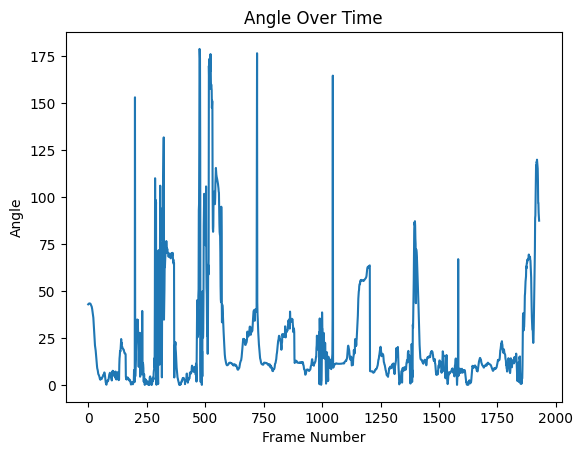

In [ ]:
plt.plot(range(len(frame_angles)),frame_angles)
plt.xlabel('Frame Number')
plt.ylabel('Angle')
plt.title('Angle Over Time')
plt.show()

### Working with the landmark list

In [ ]:
right_shoulder = (landmark_lst[0].landmark[12].x,landmark_lst[0].landmark[12].y)
right_elbow = (landmark_lst[0].landmark[14].x,landmark_lst[0].landmark[14].y)
right_wrist = (landmark_lst[0].landmark[16].x,landmark_lst[0].landmark[16].y)
frame_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
frame_angle

152.92670192370403

In [ ]:
# prompt: using  the landmark list and the helper function calculate_body_angles(). make a table of all the body angles in all frames and save it to my drive

# LANDMARKS is already defined globally

# Create an empty list to store angle data
all_body_angles = []

# Iterate over unique frames in the DataFrame
for frame_num in tqdm(np.unique(df_trail_run['frame']), desc="Processing frames"):
    df_frame = df_trail_run[df_trail_run['frame'] == frame_num]

    # Retrieve coordinates for all landmarks in a dictionary
    coordinates = {landmark: get_coords(landmark, df_frame) for landmark in LANDMARKS}

    # Calculate body vectors using the coordinates
    vectors = get_body_vecs(coordinates)

    # Calculate frame angles using the vectors
    frame_angles = calculate_body_angles(vectors)

    frame_angles['frame'] = frame_num
    all_body_angles.append(frame_angles)

# Convert to dataframe and save
angle_df = pd.DataFrame(all_body_angles)
angle_df.to_csv('/content/drive/MyDrive/body_angles_first_long_video.csv', index=False)

Processing frames: 100%|██████████| 1929/1929 [00:52<00:00, 36.67it/s]


### 3d plot

###read csv data from file and DBSCAN to detect fall in frames

Transition Frames (Fall Start Detected): [63, 66, 113, 136, 165, 200, 283, 742, 744, 807, 808, 896, 905, 906, 978, 1069, 1163, 1337, 1377, 1385, 1441, 1528, 1612, 1839]


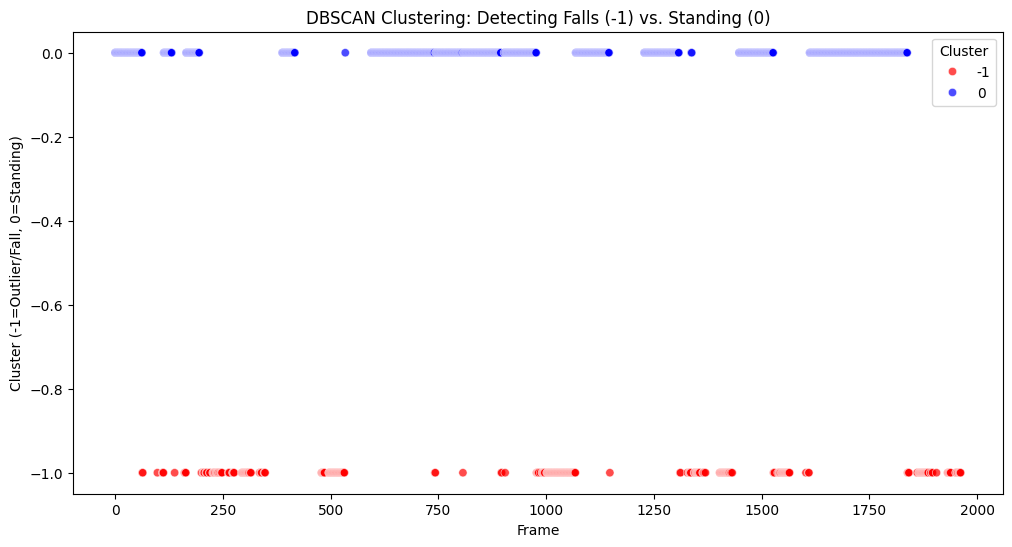

In [ ]:

# קריאת הנתונים
file_path = "/content/drive/MyDrive/videos_for_project/csv_data/body_angles_first_long_video.csv"
df = pd.read_csv(file_path)

# הסרת עמודת ה-frame לצורך עיבוד
frame_col = df['frame']  # שמירת מספרי הפריימים
features = df.drop(columns=['frame'])

# נורמליזציה של הנתונים
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


dbscan = DBSCAN(eps=0.9, min_samples=5)
df['cluster'] = dbscan.fit_predict(features_scaled)

# סינון הנתונים כך שנראה רק את הקבוצות -1 (חריגים) ו-0
df_filtered = df[df['cluster'].isin([-1, 0])]

# שחזור עמודת ה-frame
df['frame'] = frame_col

# איתור פריימים שבהם התחולל מעבר בין עמידה לרצפה (או להפך)
df['transition'] = df['cluster'].diff().abs().fillna(0)
transition_frames = df[df['transition'] == 1]['frame'].tolist()

# הצגת פריימים שבהם התחולל מעבר בין מצבים
print("Transition Frames (Fall Start Detected):", transition_frames)

# ויזואליזציה - הצגת הזוויות בפריימים מסודרים לפי הזמן
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df_filtered["frame"], y=df_filtered["cluster"],
    hue=df_filtered["cluster"], palette=["red", "blue"], alpha=0.7
)
plt.xlabel("Frame")
plt.ylabel("Cluster (-1=Outlier/Fall, 0=Standing)")
plt.title("DBSCAN Clustering: Detecting Falls (-1) vs. Standing (0)")
plt.legend(title="Cluster")
plt.show()

In [ ]:
df_filtered

,left_elbow_angle,right_elbow_angle,left_armpit_angle,right_armpit_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle,left_side_collarbone_angle,right_side_collarbone_angle,frame,cluster,transition
0,74.392874,73.154934,108.941548,82.545239,7.710224,13.314740,39.182955,33.374631,77.193461,85.835917,0,0,0.0
1,75.853864,74.493544,108.649607,81.117945,7.668716,10.071832,39.378400,34.013883,75.573638,84.469449,1,0,0.0
2,76.504699,75.506379,108.389272,80.196129,7.942891,8.080423,39.923904,35.276366,74.718522,83.705782,2,0,0.0
3,76.442315,76.230727,108.150150,79.484835,7.908010,7.161575,40.065825,35.954847,74.452947,83.403799,3,0,0.0
4,76.279119,76.708387,108.088956,79.112806,7.894684,6.745511,40.211245,36.402818,74.176149,83.128402,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,27.196659,84.309426,58.393329,35.190513,36.583386,31.688873,12.674434,9.909365,66.022336,83.355549,1958,-1,0.0
1925,35.072350,85.501137,65.448386,37.087833,35.855890,26.585111,15.917637,5.550240,68.807930,87.038634,1959,-1,0.0
1926,33.741835,80.522489,74.300359,45.369877,44.930967,32.121137,26.072268,13.763507,74.559538,94.946176,1960,-1,0.0
1927,33.220091,78.712122,75.131900,48.678839,46.654435,37.789177,28.969659,17.764750,76.507653,96.709614,1961,-1,0.0


#### Initial 3d plot

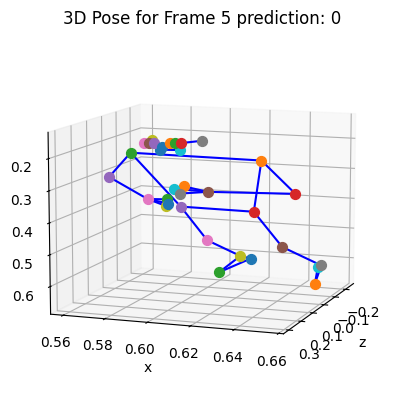

In [ ]:
# Initialize MediaPipe Pose module
mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS
frame_number = 5

# Filter the data for the desired frame
df_frame = df_trail_run[df_trail_run['frame'] == frame_number]

prediction = df_filtered[df_filtered['frame'] == frame_number]['cluster'].values[0]

# Create a dictionary mapping landmark names to their (x, y, z) coordinates
landmarks = {row['landmark']: (row['x'], row['y'], row['z']) for _, row in df_frame.iterrows()}

# Initialize the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot landmarks as scatter points
for name, (x, y, z) in landmarks.items():
    ax.scatter(-z, x, y, label=name, s=50)  # Adjusting axes to align with desired orientation

# Helper function to get coordinates by landmark name
def get_coord(name):
    """Returns the (x, y, z) coordinates of a given landmark."""
    return landmarks.get(name, (None, None, None))

# Plot lines connecting the landmarks using POSE_CONNECTIONS
for connection in POSE_CONNECTIONS:
    start, end = connection
    start_name = mp_pose.PoseLandmark(start).name
    end_name = mp_pose.PoseLandmark(end).name

    # Get the coordinates of the two landmarks
    start_coord = get_coord(start_name)
    end_coord = get_coord(end_name)

    # Check if both landmarks are available
    if None not in start_coord and None not in end_coord:
        ax.plot(
            [-start_coord[2], -end_coord[2]],  # x-coordinates
            [start_coord[0], end_coord[0]],    # y-coordinates
            [start_coord[1], end_coord[1]],    # z-coordinates
            color='blue'
        )

# Set axis labels
ax.set_zlabel('y')
ax.set_xlabel('z')
ax.set_ylabel('x')

# Flip the Z-axis to ensure head is at the top and legs at the bottom
ax.invert_zaxis()

# Rotate, tilt, and twist the graph
ax.view_init(elev=10, azim=20)  # Adjust 'elev' and 'azim' as needed

# Set plot title
plt.title(f'3D Pose for Frame {frame_number} prediction: {prediction}')

# Display the plot
plt.show()

#### Interactive 3d plot

In [ ]:
# Initialize MediaPipe Pose module
mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS
frame_number = 161

# Filter the data for the desired frame
df_frame = df_trail_run[df_trail_run['frame'] == frame_number]

# Create a dictionary mapping landmark names to their (x, y, z) coordinates
landmarks = {row['landmark']: (row['x'], row['y'], row['z']) for _, row in df_frame.iterrows()}

# Prepare lists to store points and connections
x_vals, y_vals, z_vals, names = [], [], [], []

# Collect the landmarks for plotting
for name, (x, y, z) in landmarks.items():
    x_vals.append(x)
    y_vals.append(y)
    z_vals.append(z)
    names.append(name)

# Create a 3D scatter plot for landmarks
scatter = go.Scatter3d(
    x=x_vals, y=z_vals, z=y_vals,  # Swap axes to align with your desired orientation
    mode='markers+text',
    marker=dict(size=5, color='blue'),
    text=names,  # Show names as text labels
    textposition="top center"
)

# Create line segments for each connection
connections = []
for connection in POSE_CONNECTIONS:
    start, end = connection
    start_name = mp_pose.PoseLandmark(start).name
    end_name = mp_pose.PoseLandmark(end).name

    start_coord = landmarks.get(start_name, None)
    end_coord = landmarks.get(end_name, None)

    # Ensure both landmarks exist
    if start_coord and end_coord:
        connections.append(
            go.Scatter3d(
                x=[start_coord[0], end_coord[0]],
                y=[start_coord[2], end_coord[2]],  # Swap Y and Z axes
                z=[start_coord[1], end_coord[1]],
                mode='lines',
                line=dict(color='blue', width=2)
            )
        )

# Combine scatter plot and connections into a figure
fig = go.Figure(data=[scatter] + connections)

# Set axis labels and layout
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        zaxis=dict(autorange='reversed')  # Ensure head is at the top and legs at the bottom
    ),
    title=f"3D Pose for Frame {frame_number}",
    showlegend=False
)

# Display the interactive plot
fig.show()


###create a dataframe with the landmarks as columns and the speed as rows. add the speed for every frame as a row

In [ ]:
# prompt: create a dataframe with the landmarks as columns and the speed as rows. add the speed for every frame as a row

# Assuming you have the necessary variables and functions defined (like LANDMARKS, df_trail_run)

# Create an empty list to store speed data for each frame
all_landmark_speeds = []

# Iterate through frames, calculating speed between consecutive frames
for frame_num in tqdm(range(len(np.unique(df_trail_run['frame'])) - 1), desc="Calculating speeds"):
  frame1_landmarks = create_landmark_dict_for_frame(df_trail_run, frame_num)
  frame2_landmarks = create_landmark_dict_for_frame(df_trail_run, frame_num + 30)

  landmark_speeds = calculate_speed(frame1_landmarks, frame2_landmarks, 30)  # Frame difference is 30

  landmark_speeds['frame'] = frame_num
  frame_num = frame_num + 30
  all_landmark_speeds.append(landmark_speeds)


# Convert to DataFrame
speed_df = pd.DataFrame(all_landmark_speeds)

# Reorder columns so 'frame' is first
cols = speed_df.columns.tolist()
cols.remove('frame')
speed_df = speed_df[['frame'] + cols]

# Display the DataFrame (optional)
speed_df


Calculating speeds:   9%|▉         | 174/1928 [00:07<00:51, 34.06it/s]

Calculating speeds:  10%|▉         | 186/1928 [00:08<00:50, 34.33it/s]

Calculating speeds:  11%|█         | 203/1928 [00:08<00:47, 36.29it/s]

Calculating speeds:  11%|█         | 213/1928 [00:09<01:48, 15.84it/s]

Calculating speeds:  18%|█▊        | 356/1928 [00:15<00:58, 26.79it/s]

Calculating speeds:  29%|██▉       | 567/1928 [00:27<00:47, 28.95it/s]

Calculating speeds:  59%|█████▉    | 1138/1928 [00:48<00:27, 28.51it/s]

Calculating speeds:  62%|██████▏   | 1201/1928 [00:50<00:23, 30.59it/s]

Calculating speeds:  69%|██████▊   | 1321/1928 [00:54<00:20, 30.13it/s]

Calculating speeds:  70%|██████▉   | 1343/1928 [00:55<00:19, 30.61it/s]

Calculating speeds:  73%|███████▎  | 1401/1928 [00:59<00:31, 16.84it/s]

Calculating speeds:  74%|███████▎  | 1420/1928 [01:00<00:25, 19.78it/s]

Calculating speeds:  79%|███████▊  | 1518/1928 [01:04<00:13, 29.74it/s]

Calculating speeds:  82%|████████▏ | 1587/1928 [01:06<00:11, 30.67it/s]

Calculating speeds:  95%|█████████▍| 1824/1928 [01:15<00:03, 29.36it/s]

Calculating speeds:  95%|█████████▌| 1840/1928 [01:16<00:02, 31.14it/s]

Calculating speeds: 100%|██████████| 1928/1928 [01:18<00:00, 24.43it/s]

,frame,NOSE,LEFT_SHOULDER,RIGHT_SHOULDER,LEFT_ELBOW,RIGHT_ELBOW,LEFT_WRIST,RIGHT_WRIST,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE
0,0,0.001891,0.001326,0.001435,0.000504,0.000472,0.002710,0.002056,0.000069,0.000172,0.000742,0.000266,0.001293,0.000856
1,1,0.002061,0.001339,0.001602,0.000683,0.000537,0.003085,0.001897,0.000112,0.000181,0.000846,0.000061,0.001567,0.000204
2,2,0.002216,0.001503,0.001834,0.000706,0.000653,0.003268,0.001904,0.000156,0.000197,0.000835,0.000079,0.001839,0.000114
3,3,0.002242,0.001535,0.001845,0.000771,0.000703,0.003481,0.001965,0.000230,0.000229,0.000746,0.000268,0.001692,0.000187
4,4,0.002620,0.001888,0.002264,0.000754,0.001017,0.003705,0.001898,0.000238,0.000236,0.000723,0.000320,0.001795,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,1923,0.004398,0.004660,0.004255,0.003052,0.001632,0.002348,0.002497,0.001796,0.000999,0.006367,0.006264,0.011199,0.004562
1924,1924,0.004531,0.004459,0.004108,0.002457,0.001319,0.003446,0.003038,0.001555,0.000790,0.005197,0.005304,0.010737,0.003669
1925,1925,0.004570,0.003997,0.003112,0.002917,0.001693,0.004124,0.004042,0.001408,0.000683,0.003107,0.004115,0.007377,0.001932
1926,1926,0.004613,0.004107,0.003234,0.002608,0.001280,0.004259,0.003858,0.001165,0.000442,0.002660,0.003439,0.006905,0.003615


In [ ]:
# Specify the path where you want to save the CSV file in your Google Drive
csv_file_path = '/content/drive/MyDrive/videos_for_project/csv_data/speeds_landmarks_first_long_video.csv'

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write the header row (if needed)
    csv_writer.writerow(speed_df.columns)
    # Write the data rows
    csv_writer.writerows(speed_df.values)

print(f"CSV data saved to: {csv_file_path}")


CSV data saved to: /content/drive/MyDrive/videos_for_project/csv_data/speeds_landmarks_first_long_video.csv


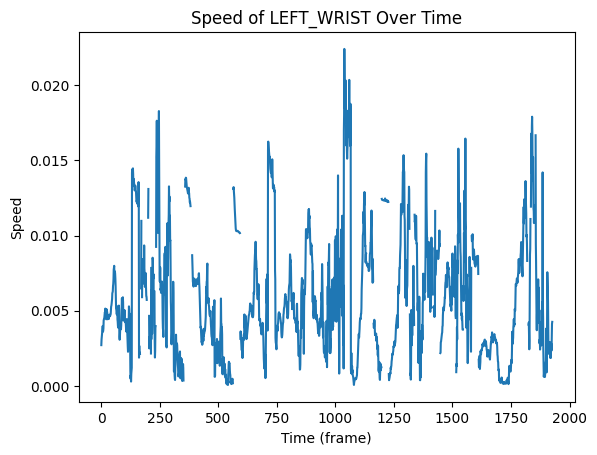

In [ ]:
# prompt: Using dataframe speed_df: view one landmark as a graph when x is time y is speed

# Import necessary libraries
import matplotlib.pyplot as plt

# Select a specific landmark (e.g., 'NOSE') and plot its speed over time
landmark_name = 'LEFT_WRIST'

# Assuming 'frame' represents time and the landmark column represents speed
plt.plot(speed_df['frame'], speed_df[landmark_name])

# Customize the plot
plt.xlabel('Time (frame)')
plt.ylabel('Speed')
plt.title(f'Speed of {landmark_name} Over Time')

# Show the plot
plt.show()


In [ ]:
# prompt: from the dataframe speed_df calculate the acceleration of each landmark

# Calculate acceleration for each landmark
acceleration_df = speed_df.copy()
for landmark in speed_df.columns[1:]:
  acceleration_df[landmark + '_acceleration'] = acceleration_df[landmark].diff()

# Display the DataFrame with acceleration (optional)
acceleration_df


,frame,NOSE,LEFT_SHOULDER,RIGHT_SHOULDER,LEFT_ELBOW,RIGHT_ELBOW,LEFT_WRIST,RIGHT_WRIST,LEFT_HIP,RIGHT_HIP,...,LEFT_ELBOW_acceleration,RIGHT_ELBOW_acceleration,LEFT_WRIST_acceleration,RIGHT_WRIST_acceleration,LEFT_HIP_acceleration,RIGHT_HIP_acceleration,LEFT_KNEE_acceleration,RIGHT_KNEE_acceleration,LEFT_ANKLE_acceleration,RIGHT_ANKLE_acceleration
0,0,0.001891,0.001326,0.001435,0.000504,0.000472,0.002710,0.002056,0.000069,0.000172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.002061,0.001339,0.001602,0.000683,0.000537,0.003085,0.001897,0.000112,0.000181,...,0.000179,0.000065,0.000374,-0.000159,0.000043,0.000010,0.000105,-0.000205,0.000274,-0.000651
2,2,0.002216,0.001503,0.001834,0.000706,0.000653,0.003268,0.001904,0.000156,0.000197,...,0.000023,0.000116,0.000184,0.000007,0.000043,0.000016,-0.000012,0.000018,0.000272,-0.000091
3,3,0.002242,0.001535,0.001845,0.000771,0.000703,0.003481,0.001965,0.000230,0.000229,...,0.000065,0.000050,0.000213,0.000061,0.000075,0.000031,-0.000088,0.000189,-0.000147,0.000074
4,4,0.002620,0.001888,0.002264,0.000754,0.001017,0.003705,0.001898,0.000238,0.000236,...,-0.000017,0.000314,0.000224,-0.000067,0.000007,0.000007,-0.000024,0.000052,0.000103,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,1923,0.004398,0.004660,0.004255,0.003052,0.001632,0.002348,0.002497,0.001796,0.000999,...,-0.000475,0.000154,-0.000365,-0.000282,-0.000114,-0.000067,-0.000191,-0.000160,0.000289,-0.000185
1924,1924,0.004531,0.004459,0.004108,0.002457,0.001319,0.003446,0.003038,0.001555,0.000790,...,-0.000595,-0.000312,0.001098,0.000541,-0.000241,-0.000209,-0.001170,-0.000959,-0.000462,-0.000893
1925,1925,0.004570,0.003997,0.003112,0.002917,0.001693,0.004124,0.004042,0.001408,0.000683,...,0.000460,0.000374,0.000678,0.001004,-0.000147,-0.000107,-0.002090,-0.001190,-0.003360,-0.001737
1926,1926,0.004613,0.004107,0.003234,0.002608,0.001280,0.004259,0.003858,0.001165,0.000442,...,-0.000309,-0.000413,0.000135,-0.000184,-0.000243,-0.000241,-0.000448,-0.000675,-0.000472,0.001683


from matplotlib import pyplot as plt
acceleration_df['frame'].plot(kind='hist', bins=20, title='frame')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['NOSE'].plot(kind='hist', bins=20, title='NOSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['LEFT_SHOULDER'].plot(kind='hist', bins=20, title='LEFT_SHOULDER')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['RIGHT_SHOULDER'].plot(kind='hist', bins=20, title='RIGHT_SHOULDER')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df.plot(kind='scatter', x='frame', y='NOSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df.plot(kind='scatter', x='NOSE', y='LEFT_SHOULDER', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df.plot(kind='scatter', x='LEFT_SHOULDER', y='RIGHT_SHOULDER', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df.plot(kind='scatter', x='RIGHT_SHOULDER', y='LEFT_ELBOW', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['frame']
  ys = series['NOSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = acceleration_df.sort_values('frame', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('frame')
_ = plt.ylabel('NOSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['frame']
  ys = series['LEFT_SHOULDER']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = acceleration_df.sort_values('frame', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('frame')
_ = plt.ylabel('LEFT_SHOULDER')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['frame']
  ys = series['RIGHT_SHOULDER']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = acceleration_df.sort_values('frame', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('frame')
_ = plt.ylabel('RIGHT_SHOULDER')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['frame']
  ys = series['LEFT_ELBOW']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = acceleration_df.sort_values('frame', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('frame')
_ = plt.ylabel('LEFT_ELBOW')

from matplotlib import pyplot as plt
acceleration_df['frame'].plot(kind='line', figsize=(8, 4), title='frame')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['NOSE'].plot(kind='line', figsize=(8, 4), title='NOSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['LEFT_SHOULDER'].plot(kind='line', figsize=(8, 4), title='LEFT_SHOULDER')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
acceleration_df['RIGHT_SHOULDER'].plot(kind='line', figsize=(8, 4), title='RIGHT_SHOULDER')
plt.gca().spines[['top', 'right']].set_visible(False)

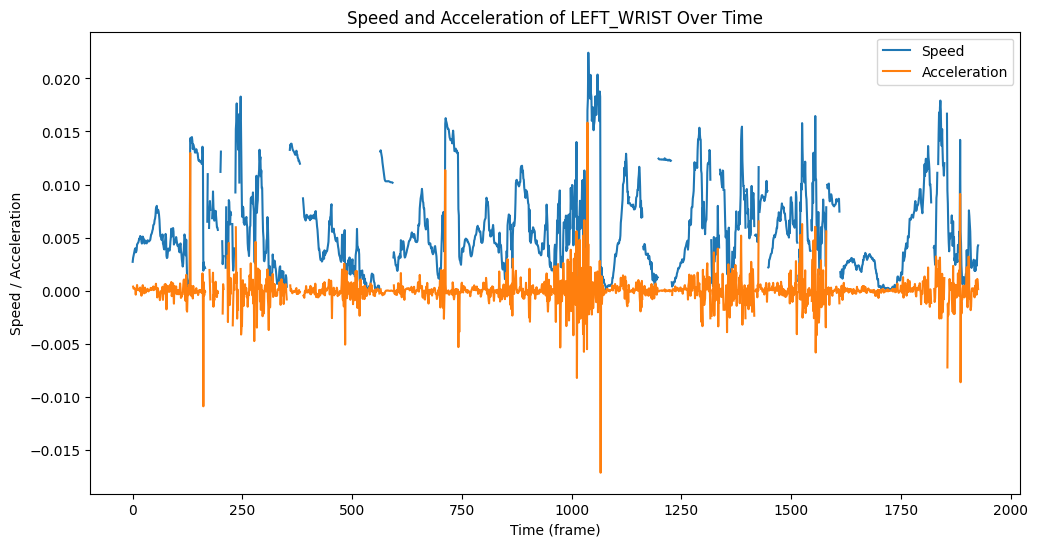

In [ ]:
# prompt: make  plot for one landmark speed and acceleration

import matplotlib.pyplot as plt
# Select a specific landmark (e.g., 'NOSE') and plot its speed and acceleration over time
landmark_name = 'LEFT_WRIST'

# Assuming 'frame' represents time and the landmark column represents speed
plt.figure(figsize=(12, 6))
plt.plot(speed_df['frame'], speed_df[landmark_name], label='Speed')
plt.plot(acceleration_df['frame'], acceleration_df[landmark_name + '_acceleration'], label='Acceleration')

# Customize the plot
plt.xlabel('Time (frame)')
plt.ylabel('Speed / Acceleration')
plt.title(f'Speed and Acceleration of {landmark_name} Over Time')
plt.legend()

# Show the plot
plt.show()


Transition Frames (Fall Start Detected): [53, 58, 98, 99, 131, 166, 170, 172, 174, 178, 200, 202, 213, 214, 215, 227, 233, 234, 241, 242, 243, 245, 249, 263, 305, 317, 318, 388, 389, 453, 454, 463, 498, 510, 525, 712, 744, 895, 905, 954, 1032, 1034, 1068, 1116, 1132, 1133, 1152, 1162, 1279, 1317, 1318, 1329, 1332, 1337, 1338, 1347, 1348, 1354, 1355, 1367, 1379, 1417, 1427, 1515, 1516, 1545, 1546, 1581, 1611, 1786, 1787, 1820, 1821, 1822, 1823, 1824, 1825, 1834, 1835, 1850, 1851, 1852, 1853, 1854, 1855, 1864, 1865, 1869, 1870, 1884, 1885, 1909, 1920, 1927]


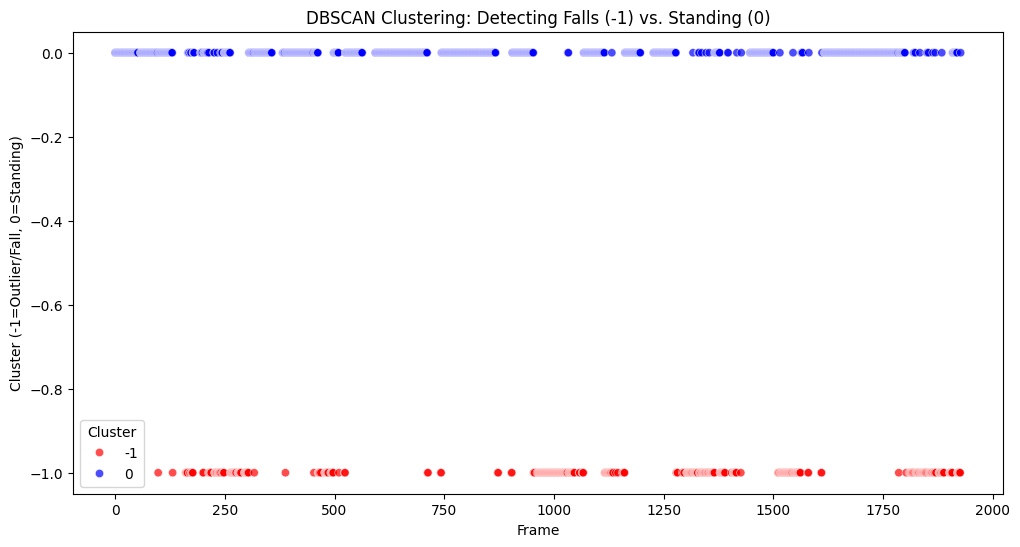

In [ ]:

# קריאת הנתונים
#file_path = "/content/drive/MyDrive/videos_for_project/csv_data/body_angles_first_long_video.csv"
#df = pd.read_csv(file_path)
df = speed_df
# הסרת עמודת ה-frame לצורך עיבוד
frame_col = df['frame']  # שמירת מספרי הפריימים
features = df.drop(columns=['frame'])
# remove NaN
features = features.fillna(0)

# נורמליזציה של הנתונים
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


dbscan = DBSCAN(eps=0.9, min_samples=5)
df['cluster'] = dbscan.fit_predict(features_scaled)

# סינון הנתונים כך שנראה רק את הקבוצות -1 (חריגים) ו-0
df_filtered = df[df['cluster'].isin([-1, 0])]

# שחזור עמודת ה-frame
df['frame'] = frame_col

# איתור פריימים שבהם התחולל מעבר בין עמידה לרצפה (או להפך)
df['transition'] = df['cluster'].diff().abs().fillna(0)
transition_frames = df[df['transition'] == 1]['frame'].tolist()

# הצגת פריימים שבהם התחולל מעבר בין מצבים
print("Transition Frames (Fall Start Detected):", transition_frames)

# ויזואליזציה - הצגת הזוויות בפריימים מסודרים לפי הזמן
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df_filtered["frame"], y=df_filtered["cluster"],
    hue=df_filtered["cluster"], palette=["red", "blue"], alpha=0.7
)
plt.xlabel("Frame")
plt.ylabel("Cluster (-1=Outlier/Fall, 0=Standing)")
plt.title("DBSCAN Clustering: Detecting Falls (-1) vs. Standing (0)")
plt.legend(title="Cluster")
plt.show()

#### fall detection from body angles and speeds

In [ ]:
body_angles_path ="/content/drive/MyDrive/videos_for_project/csv_data/first long video/body_angles_first_long_video.csv"
body_speeds_path ="/content/drive/MyDrive/videos_for_project/csv_data/first long video/speeds_landmarks_first_long_video.csv"
landmarks_path ="/content/drive/MyDrive/videos_for_project/csv_data/first long video/pose_landmarks_first_long_video.csv"

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster

def detect_falls(angles_path, speeds_path, landmarks_path, intensity_threshold_first_half=180,
                 intensity_threshold_second_half=200, min_falls=8, max_falls=12):
    # Load data
    angles_df = pd.read_csv(angles_path)
    speeds_df = pd.read_csv(speeds_path)
    landmarks_df = pd.read_csv(landmarks_path)

    # Merge datasets
    merged_df = angles_df.merge(speeds_df, on="frame", how="inner")
    landmarks_filtered = landmarks_df[['frame']].drop_duplicates()
    final_df = merged_df.merge(landmarks_filtered, on="frame", how="inner")

    # Handle missing values
    final_df.fillna(final_df.mean(), inplace=True)

    # Compute movement intensity
    movement_diff = final_df.drop(columns=['frame']).diff().abs().sum(axis=1)
    final_df['movement_intensity'] = movement_diff

    # Predict fall frames based on intensity
    predicted_fall_frames = final_df[final_df['movement_intensity'] > min(intensity_threshold_first_half,
                                                                          intensity_threshold_second_half)]['frame'].values

    # Split frames by first and second half
    mid_frame = final_df['frame'].median()
    first_half = predicted_fall_frames[predicted_fall_frames < mid_frame]
    second_half = predicted_fall_frames[predicted_fall_frames >= mid_frame]

    # Filter based on respective intensity thresholds
    first_half_filtered = [f for f in first_half if final_df.loc[f, 'movement_intensity'] > intensity_threshold_first_half]
    second_half_filtered = [f for f in second_half if final_df.loc[f, 'movement_intensity'] > intensity_threshold_second_half]
    all_filtered = np.array(first_half_filtered + second_half_filtered).reshape(-1, 1)

    # Cluster fall frames
    def find_optimal_threshold(frames, min_falls, max_falls):
        for t in np.linspace(150, 20, 20):
            Z = linkage(frames, method='ward')
            clusters = fcluster(Z, t=t, criterion='distance')
            if min_falls <= len(np.unique(clusters)) <= max_falls:
                return clusters
        return fcluster(Z, t=50, criterion='distance')

    if len(all_filtered) > 1:
        clusters = find_optimal_threshold(all_filtered, min_falls, max_falls)
        clustered_df = pd.DataFrame({'frame': all_filtered.flatten(), 'cluster': clusters})
        fall_starts = clustered_df.groupby('cluster')['frame'].min().sort_values().reset_index(drop=True)
    else:
        fall_starts = pd.Series([], dtype=int)

    return fall_starts

# Example usage:
# fall_frames = detect_falls("body_angles.csv", "body_speeds.csv", "landmarks.csv")
# fall_frames.to_csv("refined_fall_detection_results.csv", index=False)

fall_frames = detect_falls(body_angles_path, body_speeds_path, landmarks_path,intensity_threshold_second_half=100)
#fall_frames.to_csv("refined_fall_detection_results.csv", index=False)
fall_frames

,frame
0,98
1,161
2,204
3,983
4,1007
5,1039
6,1421
7,1853


In [ ]:
df_trail_run = pd.read_csv(landmarks_path)

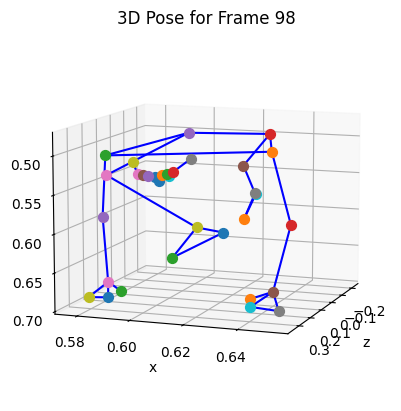

In [ ]:
# Initialize MediaPipe Pose module
mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS
frame_number = 98

# Filter the data for the desired frame
df_frame = df_trail_run[df_trail_run['frame'] == frame_number]

# Create a dictionary mapping landmark names to their (x, y, z) coordinates
landmarks = {row['landmark']: (row['x'], row['y'], row['z']) for _, row in df_frame.iterrows()}

# Initialize the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot landmarks as scatter points
for name, (x, y, z) in landmarks.items():
    ax.scatter(-z, x, y, label=name, s=50)  # Adjusting axes to align with desired orientation

# Helper function to get coordinates by landmark name
def get_coord(name):
    """Returns the (x, y, z) coordinates of a given landmark."""
    return landmarks.get(name, (None, None, None))

# Plot lines connecting the landmarks using POSE_CONNECTIONS
for connection in POSE_CONNECTIONS:
    start, end = connection
    start_name = mp_pose.PoseLandmark(start).name
    end_name = mp_pose.PoseLandmark(end).name

    # Get the coordinates of the two landmarks
    start_coord = get_coord(start_name)
    end_coord = get_coord(end_name)

    # Check if both landmarks are available
    if None not in start_coord and None not in end_coord:
        ax.plot(
            [-start_coord[2], -end_coord[2]],  # x-coordinates
            [start_coord[0], end_coord[0]],    # y-coordinates
            [start_coord[1], end_coord[1]],    # z-coordinates
            color='blue'
        )

# Set axis labels
ax.set_zlabel('y')
ax.set_xlabel('z')
ax.set_ylabel('x')

# Flip the Z-axis to ensure head is at the top and legs at the bottom
ax.invert_zaxis()

# Rotate, tilt, and twist the graph
ax.view_init(elev=10, azim=20)  # Adjust 'elev' and 'azim' as needed

# Set plot title
plt.title(f'3D Pose for Frame {frame_number}')

# Display the plot
plt.show()

#### Turn 3d plot into movie with multiple frames

In [ ]:
# Initialize MediaPipe Pose module
mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS

# Create a directory to store individual frame images
os.makedirs('frames', exist_ok=True)

# Determine the overall min and max values across all frames to set consistent axis limits
x_min, x_max = df_trail_run['x'].min(), df_trail_run['x'].max()
y_min, y_max = df_trail_run['y'].min(), df_trail_run['y'].max()
z_min, z_max = df_trail_run['z'].min(), df_trail_run['z'].max()

def get_coord(name, landmarks):
    """Returns the (x, y, z) coordinates of a given landmark."""
    return landmarks.get(name, (None, None, None))

# Generate and save plots for each frame
for frame_number in range(df_trail_run['frame'].max() + 1):
    # Filter the data for the desired frame
    df_trail_run_frame = df_trail_run[df_trail_run['frame'] == frame_number]

    if df_trail_run_frame.empty:
      # Handle the case where there are no predictions for this frame
      # You might want to skip this frame, assign a default value, or raise an exception
      print(f"Warning: No predictions found for frame {frame_number}. Skipping this frame.")
      continue  # Skip to the next frame
    prediction = df[df['frame'] == frame_number]['cluster'].values[0]



    # Create a dictionary mapping landmark names to their (x, y, z) coordinates
    landmarks = {row['landmark']: (row['x'], row['y'], row['z']) for _, row in df_trail_run_frame.iterrows()}

    # Initialize the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot landmarks as scatter points
    for name, (x, y, z) in landmarks.items():
        ax.scatter(-z, x, y, label=name, s=50)  # Adjusting axes to align with desired orientation

    # Plot lines connecting the landmarks using POSE_CONNECTIONS
    for connection in POSE_CONNECTIONS:
        start, end = connection
        start_name = mp_pose.PoseLandmark(start).name
        end_name = mp_pose.PoseLandmark(end).name

        start_coord = get_coord(start_name, landmarks)
        end_coord = get_coord(end_name, landmarks)

        # Check if both landmarks are available
        if None not in start_coord and None not in end_coord:
            ax.plot(
                [-start_coord[2], -end_coord[2]],  # x-coordinates
                [start_coord[0], end_coord[0]],    # y-coordinates
                [start_coord[1], end_coord[1]],    # z-coordinates
                color='blue'
            )

    # Set consistent axis limits
    ax.set_xlim([-z_max, -z_min])
    ax.set_ylim([x_min, x_max])
    ax.set_zlim([y_min, y_max])

    # Set axis labels
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')

    # Flip the Z-axis to ensure head is at the top and legs at the bottom
    ax.invert_zaxis()

    # Maintain aspect ratio
    ax.set_box_aspect([1, 1, 1])  # Same scaling for all axes

    # Rotate, tilt, and twist the graph
    ax.view_init(elev=10, azim=20)  # Adjust 'elev' and 'azim' as needed

    # Set plot title
    plt.title(f'3D Pose for Frame {frame_number} prediction: {prediction}')


    # Save the plot as an image
    filename = f'frames/frame_{frame_number:03d}.png'
    plt.savefig(filename)
    plt.close(fig)  # Close the figure to free memory

# Create a video from the saved images
with imageio.get_writer('pose_video_with_prediction.mp4', fps=10) as writer:
    for frame_number in range(df_trail_run['frame'].max() + 1):
        filename = f'frames/frame_{frame_number:03d}.png'
        if not os.path.exists(filename):
            continue  # Skip if the file doesn't exist
        image = imageio.imread(filename)
        writer.append_data(image)

print("Video saved as 'pose_video_with_prediction.mp4'")

<ipython-input-19-b3a68787d4a2>:94: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Video saved as 'pose_video_with_prediction.mp4'


In [ ]:
# Create a video from the saved images
with imageio.get_writer('pose_video_3.mp4', fps=10) as writer:
    for frame_number in range(df_trail_run['frame'].max() + 1):
        filename = f'frames/frame_{frame_number:03d}.png'
        if not os.path.exists(filename):
            continue  # Skip if the file doesn't exist
        image = imageio.imread(filename)
        writer.append_data(image)

print("Video saved as 'pose_video_3.mp4'")

<ipython-input-47-23b66b4c42e2>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Video saved as 'pose_video_3.mp4'


## Features

### Extract Mediapipe Landmark Features per Excercise

In [ ]:
add_new_feat = True
feat_not_to_add_lst = [
    "barbell biceps curl",
    "bench press",
    "deadlift",
    "lat pulldown",
    "pull up",
    "push-up",
    "squat",
    "t bar row",
    "tricep dips",
    "tricep pushdown",
    "chest fly machine"
]

In [ ]:
# Initialize MediaPipe Pose and Drawing modules
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Directory containing videos
video_folder = '/content/drive/MyDrive/videos_for_project/outputs'  # Update this with the path to your videos folder

# Process all videos in the directory
for excercise_type in os.listdir(video_folder):
    if add_new_feat:
        if excercise_type not in feat_not_to_add_lst:
            print(excercise_type)
            csv_data = create_features_per_excercise(video_folder, excercise_type,mp_pose)
            feat_to_parquet(csv_data, excercise_type)
            print(excercise_type)

print("All videos processed.")

pose_video_2.mp4
pose_video_2.mp4
pose_video_2__side_view_cut.mp4
pose_video_2__side_view_cut.mp4
pose_video_2 (2).mp4
pose_video_2 (2).mp4
pose_video_3.mp4
pose_video_3.mp4
All videos processed.


In [ ]:
csv_data

[]

### Feature Engineering

In [ ]:
# Create the 'data' directory if it doesn't exist
!mkdir -p /content/data

# Assuming 'pose_video_3.mp4_features.parquet' exists in the current directory
# Copy the file to the 'data' directory
!mv /content/pose_video_3.mp4_features.parquet /content/data
!mv /content/pose_video_2.mp4_features.parquet /content/data
!mv /content/pose_video_2\ \(2\).mp4_features.parquet /content/data
!mv /content/pose_video_2__side_view_cut.mp4_features.parquet /content/data

In [ ]:
exclude_lst = [
    'decline bench press_features.parquet',
    'incline bench press_features.parquet'
]

df_excercise = pd.DataFrame()
data_dir = r'/content/data'
for prqt in tqdm(os.listdir(data_dir)):
    if prqt not in exclude_lst:
        prqt_path = data_dir + '/' + prqt
        df_temp = pd.read_parquet(prqt_path)
        df_excercise = pd.concat((df_excercise,df_temp), axis=0)

100%|██████████| 4/4 [00:00<00:00, 55.42it/s]


In [ ]:
df_excercise = pd.read_parquet(r'/content/data')

In [ ]:
df_videos = df_excercise.copy()
df_videos.head()

""


### Make the Features

#### Trial Run --> One Video

In [ ]:
vid_num = 1
frame_num = 10

df_trial = df_videos[(df_videos['exc_name'] == 'bench press') &
    (df_videos['vid_num'] == vid_num) &
    (df_videos['frame'] == frame_num)
    ]
df_trial

KeyError: 'exc_name'

In [ ]:
# Retrieve and store coordinates for all landmarks in a dictionary
coordinates = {landmark: get_coords(landmark, df_trial) for landmark in LANDMARKS}
body_vecs = get_body_vecs(coordinates)
body_angles = calculate_body_angles(body_vecs)
body_heights = calculate_body_heights(coordinates)

NameError: name 'df_trial' is not defined

#### All Videos

In [ ]:
# Reshape: Group by 'vid_num' to create sequences (each sequence = one video)
label_encoder = LabelEncoder()
df_videos['exc_name_encoded'] = label_encoder.fit_transform(df_videos['exc_name'])
xyz_feat = [f'{axis}_{i}' for i in range(33) for axis in ['x', 'y', 'z']]

# Parameters
NUM_LANDMARKS = 33
FEATURES_PER_LANDMARK = 3
FRAME_FEATURES = NUM_LANDMARKS * FEATURES_PER_LANDMARK

# Ensure consistent landmark order across frames
expected_landmarks = df_videos['landmark'].unique()

# Group by video number (vid_num)
grouped_videos = df_videos.groupby(['exc_name', 'vid_num'])

# Initialize lists for videos and labels
df_videos = pd.DataFrame()
count = 0
# Process each video
for (exercise_name, vid_num), group in tqdm(grouped_videos):
    try:
        count += 1
        # Sort by frame to ensure correct sequence
        group = group.sort_values(by='frame')

        # Store frames for this video
        df_vid = pd.DataFrame()

        # Group by frame number within each video
        for frame_num, frame in group.groupby('frame'):
            # Ensure all 33 landmarks are present; fill missing ones with zeros
            frame = frame.set_index('landmark').reindex(expected_landmarks, fill_value=0)
            # Flatten the landmarks for this frame (shape: (99,))
            df_frame_x = pd.DataFrame([frame[['x', 'y', 'z']].values.flatten()], columns=xyz_feat)
            # Get the body features
            coordinates = {landmark: get_coords(landmark, frame.reset_index()) for landmark in LANDMARKS}
            body_vecs = get_body_vecs(coordinates)
            # Get the angles
            body_angles = calculate_body_angles(body_vecs)
            df_angle_frame_x = pd.DataFrame([body_angles],columns=BODY_ANGLES)
            df_frame_x = pd.concat((df_frame_x,df_angle_frame_x), axis=1)
            # Get the heights
            body_heights = calculate_body_heights(coordinates)
            df_height_frame_x = pd.DataFrame([body_heights],columns=BODY_HEIGHTS)
            df_frame_x = pd.concat((df_frame_x,df_height_frame_x), axis=1)

            # Record the video number and frame number
            df_frame_vid = pd.DataFrame({
                'vid_num': [vid_num],
                'frame_num': [frame_num]
            })
            df_frame_x = pd.concat((df_frame_x,df_frame_vid), axis=1)

            # Append this frame's info to the video DataFrame
            df_vid = pd.concat((df_vid, df_frame_x), axis=0)

            # Add the label as a final column
            # Add the label column
            df_frame_x['label'] = exercise_name

            df_vid = pd.concat((df_vid,df_frame_x), axis = 0)

        df_videos = pd.concat((df_videos,df_vid), axis=0)
        # if count == 2:
        #     break

    except Exception as e:

        print(exercise_name, e)
        break

#### Pad and Split

In [ ]:
df_videos = pd.read_parquet('video_features_22.parquet')

# Select Which Features to use
df_videos = df_videos[~df_videos['label'].isin(['decline bench press', 'incline bench press','romanian deadlift'])]

In [ ]:
label_encoder = LabelEncoder()
df_videos['exc_name_encoded'] = label_encoder.fit_transform(df_videos['label'])


# Save the LabelEncoder as a pickle file
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# Define the sequence length
desired_sequence_length = 30

# Group by 'vid_num' and get the number of videos
grouped_videos = df_videos.groupby(['label','vid_num'])

# Initialize a list to store split data
all_sequences = []
all_labels = []

for excercise_type, group_data_excercise in grouped_videos:
    group_data_excercise = group_data_excercise.reset_index(drop=True)

    # Process in chunks of `desired_sequence_length`
    for i in range(0, group_data_excercise.shape[0], desired_sequence_length):
        # Select the first `desired_sequence_length` rows
        sequence_chunk = group_data_excercise.iloc[i:i + desired_sequence_length, :]
        if sequence_chunk.shape[0] == desired_sequence_length:
            # Append the sequence to our list
            all_sequences.append(sequence_chunk.drop(['label','exc_name_encoded','vid_num','frame_num'], axis=1))
            all_labels.append(sequence_chunk['exc_name_encoded'].reset_index(drop=True)[0])
        else:
            padded_sequence = pad_sequence(sequence_chunk,desired_sequence_length )
            all_sequences.append(padded_sequence.drop(['label','exc_name_encoded','vid_num','frame_num'], axis=1))
            all_labels.append(padded_sequence['exc_name_encoded'].reset_index(drop=True)[0])

all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

## Model

### Split the data

In [ ]:
# Train/test split (80% train, 20% test)
train_X, test_X, train_y, test_y = train_test_split(
    all_sequences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Check shapes
print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")

# Ensure labels are in the correct dtype (int32)
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

### Train Models

#### Transformer Model

In [ ]:
def transformer_classifier(sequence_len, input_dim, num_classes,
                           d_model=64, num_heads=4, ff_dim=128,
                           num_layers=2, dropout_rate=0.2):
    # Input layer
    inputs = tf.keras.Input(shape=(sequence_len, input_dim))

    # Project input features to d_model dimensions
    x = tf.keras.layers.Dense(d_model)(inputs)

    # Positional Encoding with learnable embeddings
    position_embedding = tf.keras.layers.Embedding(input_dim=sequence_len, output_dim=d_model)
    positions = tf.range(start=0, limit=sequence_len, delta=1)
    pos_encoding = position_embedding(positions)
    x = x + pos_encoding  # Add positional encoding to input

    # Transformer Encoder Layers
    for _ in range(num_layers):
        # Multi-Head Attention
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feedforward Network
        ff_output = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(d_model),
        ])(attn_output)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ff_output)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dropout before final output
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer for classification
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Build and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Set hyperparameters
num_classes = len(np.unique(train_y))  # Number of exercise classes
sequence_len = train_X.shape[1]  # Number of frames (max_frames)
input_dim = train_X.shape[2]  # 99 features per frame

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3, decay_steps=10000, alpha=1e-5
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Build and compile the model
transform_model = transformer_classifier(sequence_len, input_dim, num_classes)
transform_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
transform_model.summary()

# Flatten `all_labels` to ensure it's 1D
all_labels = np.array(all_labels).flatten()

# Calculate class weights
classes = np.unique(all_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=all_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

In [ ]:
# Define the checkpoint to save the best model weights based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='transformer_19.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Train the model with class weights
history = transform_model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    batch_size=64,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_callback]
)

# Evaluate the model
loss, accuracy = transform_model.evaluate(test_X, test_y)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [ ]:
transform_model.load_weights('transformer_19.h5')
transform_model.save('transformer_19_30_frames.h5')

In [ ]:
y_pred = np.argmax(transform_model.predict(test_X), axis=1)
accuracy = accuracy_score(test_y, y_pred)
print(accuracy)

# Create confusion matrix
cm = confusion_matrix(test_y, y_pred)
display_labels = np.unique(test_y)
# Assuming y_test contains the true labels and final_predictions are the ensemble predictions

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### Hyperparamater Optimization

In [ ]:
def model_builder(hp):
    # Automatically determine the number of unique classes
    num_classes = len(np.unique(train_y))  # Make sure train_y is defined

    # Hyperparameters to tune
    d_model = hp.Int('d_model', min_value=64, max_value=256, step=64)
    num_heads = hp.Choice('num_heads', values=[4, 8, 12])
    ff_dim = hp.Int('ff_dim', min_value=128, max_value=512, step=128)
    num_layers = hp.Int('num_layers', min_value=1, max_value=4, step=1)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-5, 1e-5])

    # Build the Transformer model
    inputs = tf.keras.Input(shape=(60, 99))  # Adjust based on your input shape
    x = tf.keras.layers.Dense(d_model)(inputs)

    position_embedding = tf.keras.layers.Embedding(input_dim=60, output_dim=d_model)
    positions = tf.range(start=0, limit=60, delta=1)
    pos_encoding = position_embedding(positions)
    pos_encoding = tf.keras.layers.Dense(d_model)(pos_encoding)
    x = x + pos_encoding

    for _ in range(num_layers):
        x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x_norm, x_norm)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output

        ff_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        ff_output = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(d_model)
        ])(ff_norm)
        x = x + ff_output

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer with correct number of classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Compile the model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_tuning_dir',
    project_name='transformer_tuning'
)

In [ ]:
tuner.search(train_X, tf.keras.utils.to_categorical(train_y),
             validation_data=(test_X, tf.keras.utils.to_categorical(test_y)),
             epochs=50, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best d_model: {best_hps.get('d_model')}")
print(f"Best num_heads: {best_hps.get('num_heads')}")
print(f"Best ff_dim: {best_hps.get('ff_dim')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

In [ ]:
def build_final_model(best_hps):
    num_classes = len(np.unique(train_y))
    # Extract hyperparameters from the best_hps object
    d_model = best_hps.get('d_model')
    num_heads = best_hps.get('num_heads')
    ff_dim = best_hps.get('ff_dim')
    num_layers = best_hps.get('num_layers')
    dropout_rate = best_hps.get('dropout_rate')
    learning_rate = best_hps.get('learning_rate')

    # Define the Transformer model using the best hyperparameters
    inputs = tf.keras.Input(shape=(60, 99))
    x = tf.keras.layers.Dense(d_model)(inputs)

    # Positional encoding
    position_embedding = tf.keras.layers.Embedding(input_dim=60, output_dim=d_model)
    positions = tf.range(start=0, limit=60, delta=1)
    pos_encoding = position_embedding(positions)
    pos_encoding = tf.keras.layers.Dense(d_model)(pos_encoding)
    x = x + pos_encoding

    # Transformer encoder layers
    for _ in range(num_layers):
        x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x_norm, x_norm)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        x = x + attn_output  # Residual connection

        ff_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        ff_output = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(d_model),
        ])(ff_norm)
        x = x + ff_output

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Final dropout and output layer
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Compile the model with the best learning rate
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Build the model with the best hyperparameters
final_model = build_final_model(best_hps)

# Print the model summary to verify the architecture
final_model.summary()

# Train the model
history = final_model.fit(
    train_X, tf.keras.utils.to_categorical(train_y),
    validation_data=(test_X, tf.keras.utils.to_categorical(test_y)),
    epochs=200, batch_size=32,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_final_model.h5', save_best_only=True)
    ]
)


In [ ]:
y_pred = np.argmax(final_model.predict(test_X), axis=1)
# Create confusion matrix
cm = confusion_matrix(test_y, y_pred)
display_labels = np.unique(test_y)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Test Model Real Time

In [ ]:
transform_model = tf.keras.models.load_model('transformer_19.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'transformer_19.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#### Mediapipe features live

In [ ]:
# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils


# Parameters
NUM_LANDMARKS = 33
FEATURES_PER_LANDMARK = 3
FRAME_FEATURES =  147
WINDOW_SIZE = 120
chosen_model = transform_model
# Video source
video_path = r'\pose_detection\Random Workout clips.mp4'
cap = cv2.VideoCapture(video_path)

# Initialize a buffer for 60 frames
buffer = []

# Create a named window and set its size only once
cv2.namedWindow("Live Prediction", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Live Prediction", 300, 300)  # Set the window to the desired size

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame with Mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )
        # Extract landmarks and flatten to (99,)
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()

        if landmarks.shape[0] == FRAME_FEATURES:
            # Add the frame to the buffer
            buffer.append(landmarks)

            # If buffer exceeds 60 frames, remove the oldest frame
            if len(buffer) > WINDOW_SIZE:
                buffer.pop(0)

            # Make a prediction when buffer has exactly 60 frames
            if len(buffer) == WINDOW_SIZE:
                input_data = np.expand_dims(np.array(buffer), axis=0)

                # Uncomment after loading your model
                prediction = chosen_model.predict(input_data)
                print(prediction)
                predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

                # Simulate a prediction label for now
                # predicted_label = "Sample Exercise"

                # Display the prediction on the frame
                cv2.putText(frame, f'Exercise: {predicted_label}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the frame in the correctly sized window
    cv2.imshow("Live Prediction", frame)

    # Exit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
pose.close()

#### Many Features live

In [ ]:
# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

xyz_feat = [f'{axis}_{i}' for i in range(33) for axis in ['x', 'y', 'z']]

# Parameters
NUM_FEATURES =  147
WINDOW_SIZE = 60  # Adjust to your model input size
chosen_model = transform_model
# Video source
video_path = r"pose_detection\doron_random_filter.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize a buffer for 60 frames
buffer = []
predicted_label = None

# Create a named window and set its size only once
cv2.namedWindow("Live Prediction", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Live Prediction", 300, 300)  # Set the window to the desired size
frame_feature_sequences = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame with Mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
        coordinates = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            # print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
            coordinates[mp_pose.PoseLandmark(idx).name] = [landmark.x, landmark.y, landmark.z]

        body_vecs = get_body_vecs(coordinates)
        # Get the angles
        body_angles = calculate_body_angles(body_vecs)
        # Get the heights
        body_heights = calculate_body_heights(coordinates)

        frame_feature_sequence = list(landmarks) + list(body_angles.values()) + list(body_heights.values())

        frame_feature_sequences.append(frame_feature_sequence)
        # print(len(frame_feature_sequences))
        if len(frame_feature_sequences) == WINDOW_SIZE:
                frame_feature_array = np.array(frame_feature_sequences)
                frame_feature_array = np.expand_dims(frame_feature_array, axis=0)
                # Uncomment after loading your model
                prediction = chosen_model.predict(frame_feature_array)

                predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))
                print(predicted_label)
                # Display the prediction on the frame
                cv2.putText(frame, f'Exercise: {predicted_label}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

                frame_feature_sequences = []

        else:
            if predicted_label:
                                  # Display the prediction on the frame
                cv2.putText(frame, f'Exercise: {predicted_label}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            else:
                                 # Display the prediction on the frame
                cv2.putText(frame, 'detecting excercise', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the frame in the correctly sized window
    cv2.imshow("Live Prediction", frame)

    # Exit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
pose.close()

#### Many features process

In [ ]:
# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

xyz_feat = [f'{axis}_{i}' for i in range(33) for axis in ['x', 'y', 'z']]

# Parameters
NUM_FEATURES = 147
WINDOW_SIZE = 60  # Adjust to your model input size
chosen_model = transform_model
# Video source
video_path = r"\pose_detection\doron_random_filter.mp4"
cap = cv2.VideoCapture(video_path)

# Get the total number of frames for progress calculation
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize a buffer for 60 frames
buffer = []
predicted_label = None

frame_feature_sequences = []

# Video writer setup
output_path = r'pose_detection\process_doron_random_filter.mp4'
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
original_fps = cap.get(cv2.CAP_PROP_FPS)
output_fps = original_fps * 2  # Save at double speed

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, output_fps, (frame_width, frame_height))

# Track the current frame count
current_frame = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame with Mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
        coordinates = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            coordinates[mp_pose.PoseLandmark(idx).name] = [landmark.x, landmark.y, landmark.z]

        body_vecs = get_body_vecs(coordinates)
        # Get the angles
        body_angles = calculate_body_angles(body_vecs)
        # Get the heights
        body_heights = calculate_body_heights(coordinates)

        frame_feature_sequence = list(landmarks) + list(body_angles.values()) + list(body_heights.values())
        frame_feature_sequences.append(frame_feature_sequence)

        if len(frame_feature_sequences) == WINDOW_SIZE:
                frame_feature_array = np.array(frame_feature_sequences)
                frame_feature_array = np.expand_dims(frame_feature_array, axis=0)
                # Uncomment after loading your model
                prediction = chosen_model.predict(frame_feature_array)

                predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

                frame_feature_sequences = []

        # Overlay the prediction on the frame
        if predicted_label:
            cv2.putText(frame, f'Exercise: {predicted_label}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        else:
            cv2.putText(frame, 'Detecting exercise...', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

    # Update progress
    current_frame += 1
    progress = (current_frame / total_frames) * 100
    print(f"Processing: {progress:.2f}% complete", end='\r')

# Cleanup
cap.release()
pose.close()
out.release()

print("\nProcessing complete.")


In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

xyz_feat = [f'{axis}_{i}' for i in range(33) for axis in ['x', 'y', 'z']]

# Parameters
NUM_FEATURES = 147
WINDOW_SIZE = 60  # Adjust to your model input size
chosen_model = transform_model
video_path = r"\pose_detection\doron_random_filter.mp4"
cap = cv2.VideoCapture(video_path)

# Limit the number of frames processed to 1000
frame_limit = 1000

# Initialize a buffer for 60 frames
buffer = []
predicted_label = None
frame_feature_sequences = []

# Video writer setup
output_path = r'\pose_detection\process_doron_random_filter_1000.mp4'
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
original_fps = cap.get(cv2.CAP_PROP_FPS)
output_fps = original_fps * 2  # Save at double speed

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, output_fps, (frame_width, frame_height))

# Track the current frame count
current_frame = 0

while cap.isOpened() and current_frame < frame_limit:
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame with Mediapipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS
            )
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
        coordinates = {}
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            coordinates[mp_pose.PoseLandmark(idx).name] = [landmark.x, landmark.y, landmark.z]

        body_vecs = get_body_vecs(coordinates)
        body_angles = calculate_body_angles(body_vecs)
        body_heights = calculate_body_heights(coordinates)

        frame_feature_sequence = list(landmarks) + list(body_angles.values()) + list(body_heights.values())
        frame_feature_sequences.append(frame_feature_sequence)

        if len(frame_feature_sequences) == WINDOW_SIZE:
                frame_feature_array = np.array(frame_feature_sequences)
                frame_feature_array = np.expand_dims(frame_feature_array, axis=0)
                # Uncomment after loading your model
                prediction = chosen_model.predict(frame_feature_array)

                predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

                frame_feature_sequences = []

        # Overlay the prediction on the frame
        if predicted_label:
            cv2.putText(frame, f'Exercise: {predicted_label}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        else:
            cv2.putText(frame, 'Detecting exercise...', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

    # Update progress
    current_frame += 1
    progress = (current_frame / frame_limit) * 100
    print(f"Processing: {progress:.2f}% complete", end='\r')

# Cleanup
cap.release()
pose.close()
out.release()

print("\nProcessing complete.")
